# Libraries

In [2]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from utils_soundfields import plot_sf, plot_rir
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from aux_files import FCN, PINNDataset
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker
# from sklearn.model_selection import train_test_split
from icecream import ic
import numpy as np
import time
# import scipy.io
import pandas as pd

#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == 'cuda': 
    print(torch.cuda.get_device_name())

cpu


plot_rir# Problem Setup
https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

**2D Wave Equation**

$$\frac{\partial^2 p}{\partial t^2} = c^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} \right) \rightarrow$$
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}  - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = 0$$

$$x, y \in[-1,1]$$
$$t\in[0,1]$$


# Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

###Example

(See: https://book.sciml.ai/notes/10/)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)




# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

(See: https://arxiv.org/abs/1711.10566)

**Inverse Problem**: Data$→$Model's parameters so:

Data →PINN→ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$p_{tt}+\mathscr{N}[p; c]=0$$

where, $p(\mathbf{r},t)$ is the hidden solution and $\mathscr{N}[p;c]$ is a nonlinear operator.

In short: We will use a PINN to get $p(\mathbf{r}^{\prime},t)$ in positions $\mathbf{r}^{\prime}$.


## Analysis:

Let:

$p_{tt}=\frac{\partial^2 p}{\partial t^2}$

$p_{xx}=\frac{\partial^2 u}{\partial x^2}$
$p_{yy}=\frac{\partial^2 u}{\partial y^2}$

$\mathscr{N}[p;c]=c^2 \left( p_{xx} + p_{yy} \right)$

Our PDE is described as:

$$p_{tt} - c^2 \left( p_{xx} + p_{yy} \right)=0$$

Or,

$$p_{tt} -\mathscr{N}[p]=0$$













## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$N(\mathbf{r},t)\approx u(\mathbf{r},t)$$

Since N(\mathbf{r},t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(\mathbf{r}, t)\approx p(\mathbf{r}, t)$$

Then:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right) \approx p_{tt} - c^2 \left(p_{xx} + p_{yy} \right)=0$$

And:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)\approx 0$$


We define this function as $f$:

$$f(\mathbf{r}, t)=N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)$$

Remember our operator:

$$f(\mathbf{r}, t)=N_t+\mathscr{N}[N,c]$$

So:

$$f(\mathbf{r}, t)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($L$) inside our domain $(\mathbf{r},t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{L}\sum^{L}_{i=1}|f(\mathbf{r}_p^i,t_p^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_{\mathbf{r}}$** (compare it to the reference solution).

$$MSE_{\mathbf{r}}=\frac{1}{L}\sum^{L}_{i=1}|p(\mathbf{r}_p^i, t_{p}^i)-N(\mathbf{r}_p^i, t_{p}^i)|^2$$

Please note that $\{\mathbf{r}_p^i, t_{p}^i\}_{i=1}^L$ are the same in $MSE_f$ and $MSE_{\mathbf{r}}$

#### Total Loss:

$$MSE=MSE_{\mathbf{r}}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the PDEs parameters (i.e., $p(\mathbf{r}^{\prime}, t)$)→ We will ask our neural network to find our $p(\mathbf{r}^{\prime})$.

### Neural Network

In [6]:
data = np.load('../ISM_sphere.npz')
keys = [key for key in data.keys()]
print("datafile keys: ",keys)

datafile keys:  ['array_data', 'reference_data', 'grids_sphere', 'grid_reference', 'snr', 'rt60', 'room_coords', 'room_height', 'source_coords', 'fs']


/var/folders/7f/_3r2l49x0ml1dqnf75pb0slm0000gp/T/ipykernel_11556/478848080.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


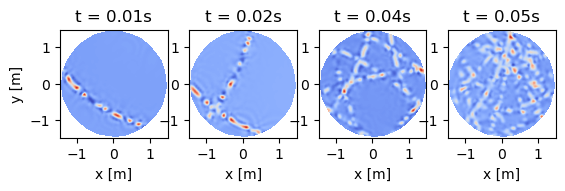

In [7]:
rirdata = data['reference_data']
fs = data['fs']
grid = data['grid_reference']
t_test1 = int(fs*0.015)
t_test2 = int(fs*0.02)
t_test3 = int(fs*0.035)
t_test4 = int(fs*0.05)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1, _ = plot_sf(rirdata[:, t_test1], grid[0], grid[1], ax = ax1, name = 't = {:.2f}s'.format(t_test1/fs))
ax2, _ = plot_sf(rirdata[:, t_test2], grid[0], grid[1], ax = ax2,  name = 't = {:.2f}s'.format(t_test2/fs))
ax3, _ = plot_sf(rirdata[:, t_test3], grid[0], grid[1], ax = ax3,  name = 't = {:.2f}s'.format(t_test3/fs))
ax4, _ = plot_sf(rirdata[:, t_test4], grid[0], grid[1], ax = ax4,  name = 't = {:.2f}s'.format(t_test4/fs))
for ax in (ax2, ax3, ax4):
    ax.set_ylabel('')
fig.show()

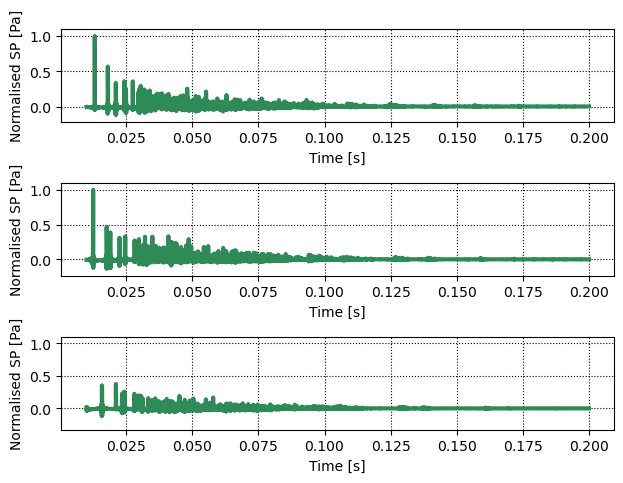

In [8]:
fig, ax = plt.subplots(3, 1)
ax[0] = plot_rir(rirdata[4], ax = ax[0])
ax[1] = plot_rir(rirdata[254], ax = ax[1])
ax[2] = plot_rir(rirdata[888], ax = ax[2])
fig.tight_layout()
plt.show()

## Prepare Data

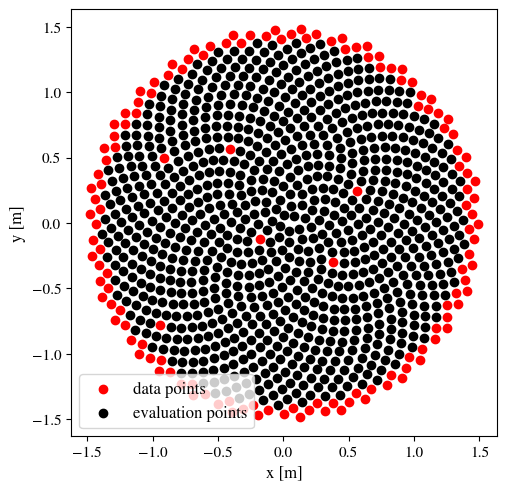

In [9]:
data = rirdata[:, :int(0.25*fs)] # truncate
t = np.linspace(0, 0.25, int(0.25*fs)) # Does not need normalisation if < 1 second
t_ind = np.arange(0, int(0.25*fs))
x_true = grid[0]
y_true = grid[1]
# boundary indices
boundary_ind = np.argwhere(x_true**2 + y_true**2 > (1.4)**2)
# regular point indices
mask = np.ones(grid.shape[1], dtype=bool)
mask[boundary_ind] = False
reg_ind = np.argwhere(mask == True)
# random interpolation indices
interp_indx = np.random.choice(reg_ind.squeeze(-1), 7, replace=False)# Randomly chosen points for Interior
# add to boundary indices
data_ind = np.vstack((boundary_ind, interp_indx[..., None])).squeeze(-1)
# regular point grid
mask = np.ones(grid.shape[1], dtype=bool)
mask[data_ind] = False
grid_rest = grid[:, mask]
# plot data points (spatial data points only e.g. not regarding time)
plt.scatter(grid[0, data_ind], grid[1, data_ind], color = 'red')
plt.scatter(grid_rest[0], grid_rest[1], color = 'k')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(['data points', 'evaluation points'])
plt.gca().set_aspect('equal')
plt.show()

## Training Data

In [11]:
batch_size = 30
total_batch_size = batch_size*len(x_true)
dataset = PINNDataset(data, x_true, y_true, t, data_ind, boundary_ind,
                      t_ind, device= device)
train_dataloader = DataLoader(dataset, batch_size= batch_size, shuffle = True)

total_points=len(x_true)*len(y_true)*len(t)
total_training_points =len(x_true[data_ind])*len(y_true[data_ind])*len(t)
total_bc_points =len(x_true[boundary_ind])*len(y_true[boundary_ind])*len(t)
print("We have",total_points,"data points in total. We will select",total_training_points,"points to train our model (data term) and",total_bc_points,"for the boundary condition enforcement.")

We have 4000000000 data points in total. We will select 73984000 points to train our model (data term) and 66564000 for the boundary condition enforcement.


In [14]:
steps=20000
lr=1e-1
layers = np.array([3,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [15]:
PINN = FCN(layers, bounds = [1.6, 1.], device = device,
           total_batch_size= total_batch_size)

params = list(PINN.dnn.parameters())

'''Optimization'''
# 'L-BFGS Optimizer'
# optimizer = torch.optim.LBFGS(params, lr,
#                               max_iter = steps,
#                               max_eval = None,
#                               tolerance_grad = 1e-11,
#                               tolerance_change = 1e-11,
#                               history_size = 100,
#                               line_search_fn = 'strong_wolfe')
optimizer = torch.optim.Adam(params, lr)
'Neural Network Summary'
print(PINN.dnn)


DNN(
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [ ]:
# time = time.time()
for batch in train_dataloader:
    train_input = batch['collocation_train']
    test_input = batch['collocation_all']
    p_train = batch['pressure_batch']
    p_test = batch['pressure_all']
    optimizer.zero_grad()
    PINN.SGD_step(train_input, test_input, p_train, p_test)


# elapsed = time.time() - start_time
# print('Training time: %.2f' % (elapsed))
#
#
# ''' Model Accuracy '''
# error_vec, u_pred = PINN.test()
#
# print('Test Error: %.5f'  % (error_vec))

/Users/xen/miniconda3/envs/DSC_project/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30, 1, 136])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Plots

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5]  Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics Informed Deep Learning (part ii): Data-driven Discovery of Nonlinear Partial Differential Equations. arXiv preprint arXiv:1711.10566. https://arxiv.org/abs/1711.10566

[6] Repository: PPhysics-Informed Deep Learning and its Application in Computational Solid and Fluid Mechanics.https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics.

